## CSCE 5290 - Fall 2021
### Final Project - Part 2
Seq2Seq Tutorial adapted to use the CNN/DailyMail dataset.

The dataset has been pre-cleaned and truncated in the CNN Process to CSV notebook.
Here we just load it straight into a Pandas dataframe for training and split it from there.

### Downloading the data

In [1]:
# Install the TF and SpaCy dependencies
%%capture
!pip install tensorflow-text
!python -m spacy download en_core_web_sm

In [2]:
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np

In [3]:
# Get the data
!gdown --id 1tXe-Jh84Nc_RENVzXL-5rAL1SMLJrv7Q

Downloading...
From: https://drive.google.com/uc?id=1tXe-Jh84Nc_RENVzXL-5rAL1SMLJrv7Q
To: /content/cnn_post_pre_50k.csv
100% 115M/115M [00:01<00:00, 108MB/s] 


### Seq2Seq Baseline Model
The preprocessing & model code is from this link:
https://blog.paperspace.com/introduction-to-seq2seq-models/

The intention is to train a fully functional Keras model that can do Seq2Seq abstractive summarization. 

In [4]:
post_pre = pd.read_csv('cnn_post_pre_50k.csv')
post_pre = post_pre[['text', 'summary']]
post_pre.head(5)

,text,summary
0,by associated press published 14:11 est 25 oct...,sostok _START_ bishop john folda of north dako...
1,ralph mata was an internal affairs lieutenant...,sostok _START_ criminal complaint cop used his...
2,he been accused of making many fashion faux pa...,sostok _START_ prime minister and his family a...
3,beirut syria carried out an airstrike on refug...,sostok _START_ airstrike kills nine syrians in...
4,kabul afghanistan china top security official ...,sostok _START_ china top security official vis...


In [5]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']), test_size=0.1, random_state=128, shuffle=False)

In [6]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [7]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ",(cnt / tot_cnt) * 100)

% of rare words in vocabulary:  64.75263170125253


In [8]:
max_text_len = 500
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 60673


In [9]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [10]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

% of rare words in vocabulary: 69.71909044844186


In [11]:
max_summary_len = 50
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 19124


In [12]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [13]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

### Model Construction and Training

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 500, 200)     12134600    ['input_3[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 500, 300),   601200      ['embedding_2[0][0]']            
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                            

In [19]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [22]:
# Note: this will take a while. Run as many epochs as needed.
history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], epochs=15, callbacks=[es], batch_size=150, validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/15
300/300 [==============================] - 1083s 4s/step - loss: 5.4500 - val_loss: 5.0618
Epoch 2/15
300/300 [==============================] - 1075s 4s/step - loss: 4.9882 - val_loss: 4.7696
Epoch 3/15
300/300 [==============================] - 1080s 4s/step - loss: 4.7541 - val_loss: 4.5942
Epoch 4/15
300/300 [==============================] - 1072s 4s/step - loss: 4.5659 - val_loss: 4.4588
Epoch 5/15
300/300 [==============================] - 1068s 4s/step - loss: 4.4323 - val_loss: 4.3640
Epoch 6/15
300/300 [==============================] - 1073s 4s/step - loss: 4.3304 - val_loss: 4.2936
Epoch 7/15
300/300 [==============================] - 1081s 4s/step - loss: 4.2440 - val_loss: 4.2407
Epoch 8/15
300/300 [==============================] - 1066s 4s/step - loss: 4.1710 - val_loss: 4.1921
Epoch 9/15
300/300 [==============================] - 1080s 4s/step - loss: 4.1045 - val_loss: 4.1516
Epoch 10/15
300/300 [==============================] - 1075s 4s/step - loss: 4.047

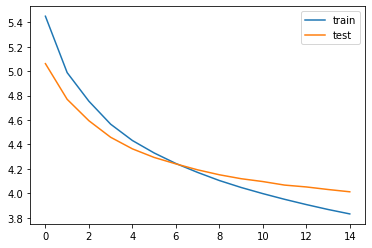

In [23]:
# Runtime -> Run After from here after training.

from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [25]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [26]:
def decode_sequence(input_seq):
    
  # Encode the input as state vectors.
  e_out, e_h, e_c = encoder_model.predict(input_seq)
  
  # Generate empty target sequence of length 1
  target_seq = np.zeros((1,1))
  
  # Populate the first word of target sequence with the start word.
  target_seq[0, 0] = target_word_index['sostok']

  stop_condition = False
  decoded_sentence = ''
  
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_word_index[sampled_token_index]
    
    if(sampled_token != 'eostok'):
        decoded_sentence += ' ' + sampled_token

    # Exit condition: either hit max length or find stop word.
    if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1)):
        stop_condition = True

    # Update the target sequence (of length 1)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # Update internal states
    e_h, e_c = h, c

  return decoded_sentence

In [27]:
# To convert sequence to summary
def seq2summary(input_seq):
  newString = ''
  for i in input_seq:
    if ((i != 0 and i != target_word_index['sostok']) and i!= target_word_index['eostok']):
      newString = newString + reverse_target_word_index[i] + ' '
          
  return newString

# To convert sequence to text
def seq2text(input_seq):
  newString = ''
  for i in input_seq:
    if i != 0:
      newString = newString + reverse_source_word_index[i] + ' '
          
  return newString

In [28]:
for i in range(0, 5):
  print("Review:", seq2text(x_tr[i]))
  print("Original summary:", seq2summary(y_tr[i]))
  print("Predicted summary:", decode_sequence(x_tr[i].reshape(1, max_text_len)))
  print("\n")

Review: by associated press published 14 11 est 25 october 2013 updated 15 36 est 25 october 2013 the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john pictured of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis state immunization program manager molly howell says the risk is low but officials feel it important to alert people to the possible exposure the diocese announced on monday that bishop john is taking time off after being diagnosed with hepatitis the diocese says he contracted the infection through contaminated food while attending conference for newly ordained bishops in italy last month symptoms of hepati

In [29]:
!mkdir -p saved_model
model.save('saved_model/seq2seq_cnn_50k')

INFO:tensorflow:Assets written to: saved_model/seq2seq_cnn_50k/assets


In [30]:
!zip -r seq2seq_cnn_50k.zip saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/seq2seq_cnn_50k/ (stored 0%)
  adding: saved_model/seq2seq_cnn_50k/variables/ (stored 0%)
  adding: saved_model/seq2seq_cnn_50k/variables/variables.index (deflated 67%)
  adding: saved_model/seq2seq_cnn_50k/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/seq2seq_cnn_50k/assets/ (stored 0%)
  adding: saved_model/seq2seq_cnn_50k/saved_model.pb (deflated 91%)
  adding: saved_model/seq2seq_cnn_50k/keras_metadata.pb (deflated 93%)


In [31]:
# Create comparison artifacts for ROUGE scoring
limit = 100 # because this takes forever

ref_file = 'cnn_ref.txt'
pred_file = 'cnn_pred.txt'

from tqdm import tqdm
with open(ref_file, 'w') as f_ref:
  for i, line in enumerate(tqdm(y_tr)):
    f_ref.write(seq2summary(y_tr[i]))
    if i > limit:
      break

with open(pred_file, 'w') as f_pred:
  for i, line in enumerate(tqdm(x_tr)):
    f_pred.write(decode_sequence(x_tr[i].reshape(1, max_text_len)))
    if i > limit:
      break

  0%|          | 101/45000 [04:35<34:00:52,  2.73s/it]


In [32]:
!pip install rouge

In [33]:
# Average rouge scoring
from rouge import FilesRouge

In [35]:
import sys
fr = FilesRouge()
sys.setrecursionlimit(250 * 250 + 10)
scores = fr.get_scores(pred_file, ref_file, avg=True)

In [36]:
scores

{'rouge-1': {'f': 0.2276585093475613,
  'p': 0.6514285714285715,
  'r': 0.13793103448275862},
 'rouge-2': {'f': 0.08788093215853379,
  'p': 0.20666666666666667,
  'r': 0.0558055805580558},
 'rouge-l': {'f': 0.07588616785979305,
  'p': 0.21714285714285714,
  'r': 0.04597701149425287}}